Missing values per column:
 SZA           0
AOD           0
COD           0
CLD_FRAC      0
UW            0
TO3           0
Pressure      0
BSA           0
WSA           0
SW_direct     0
SW_diffuse    0
dtype: int64


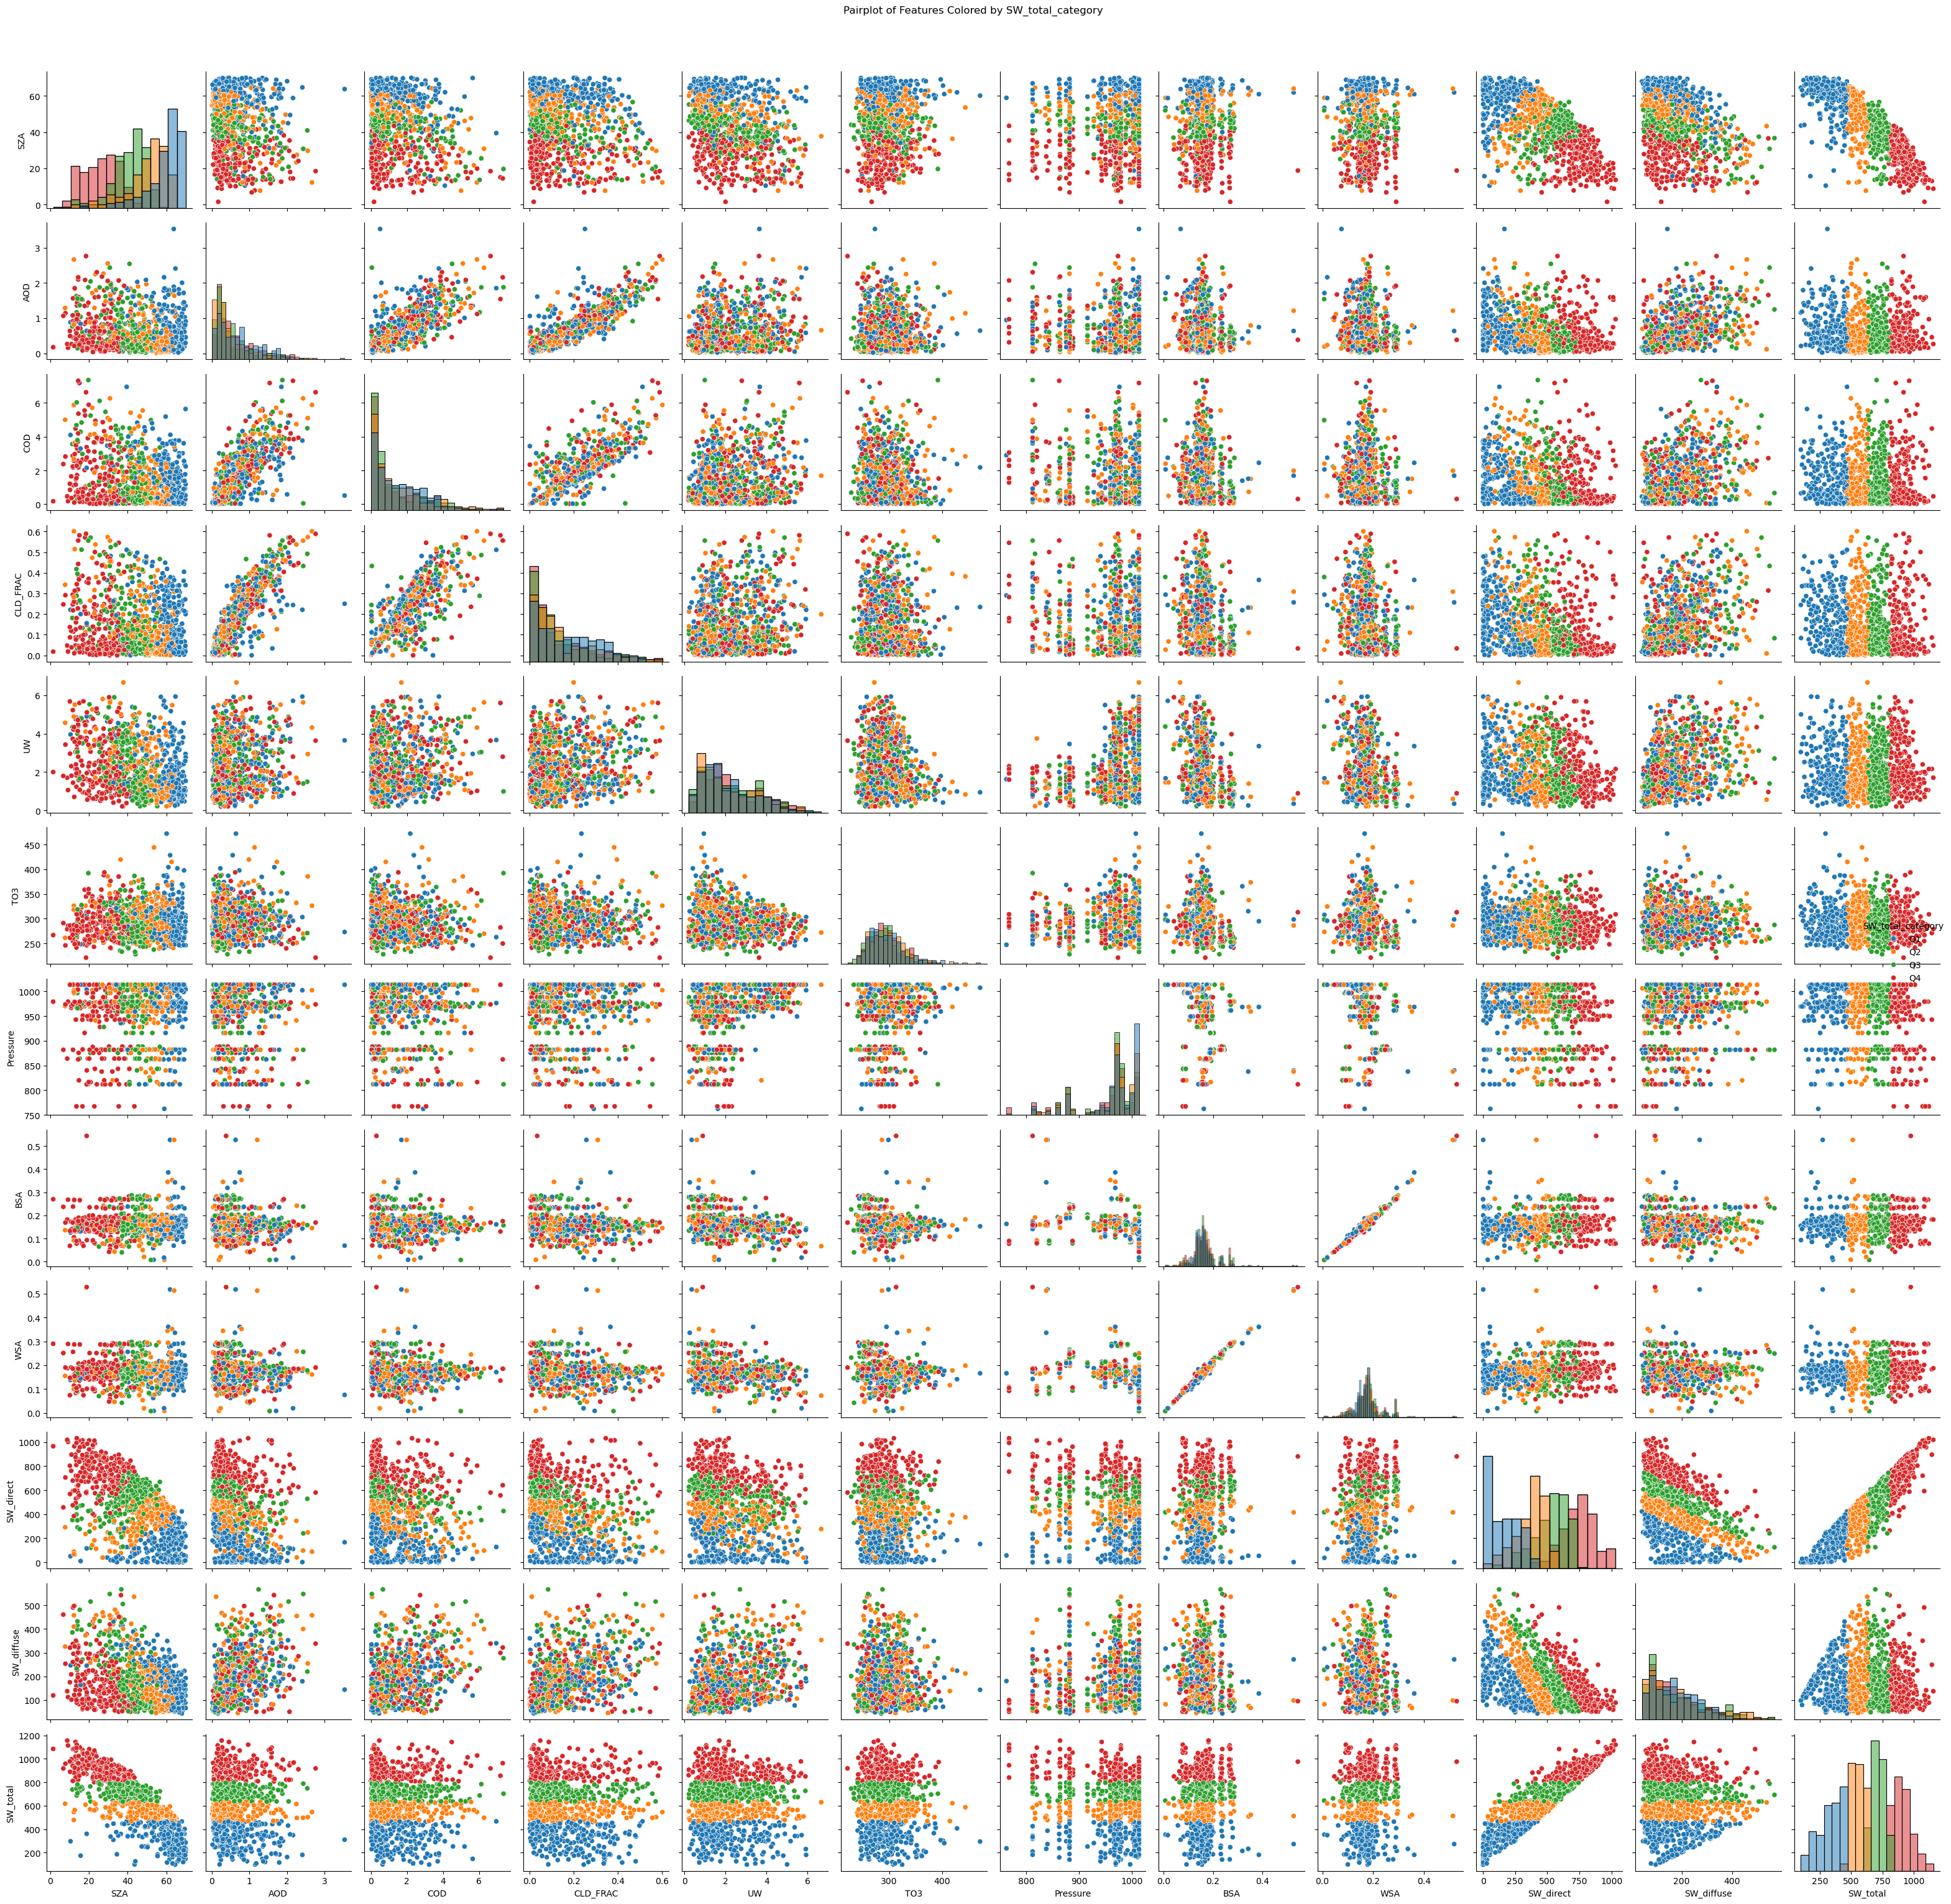

In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Part 1: Data Preprocessing

# loading in the dataset 
df = pd.read_csv("SW_with_AOD.csv")
print("Missing values per column:\n", df.isnull().sum()) # this checks for missing values 
df.dropna(inplace=True) # this drops any missing/NA values

# creat a new column 
df["SW_total"] = df["SW_direct"] + df["SW_diffuse"]

# create a new categorical column 
df["SW_total_category"] = pd.qcut(df["SW_total"], q=4, labels=["Q1", "Q2", "Q3", "Q4"])

# visualize relationships with Seaborn pairplot
df_sample = df.sample(n=1000, random_state=42)

sns.pairplot(
    df_sample,
    hue="SW_total_category",
    vars=["SZA", "AOD", "COD", "CLD_FRAC", "UW", "TO3", "Pressure", 
          "BSA", "WSA", "SW_direct", "SW_diffuse", "SW_total"],
    diag_kind="hist"
)
plt.suptitle("Pairplot of Features Colored by SW_total_category", y=1.02)
plt.tight_layout()
plt.show()

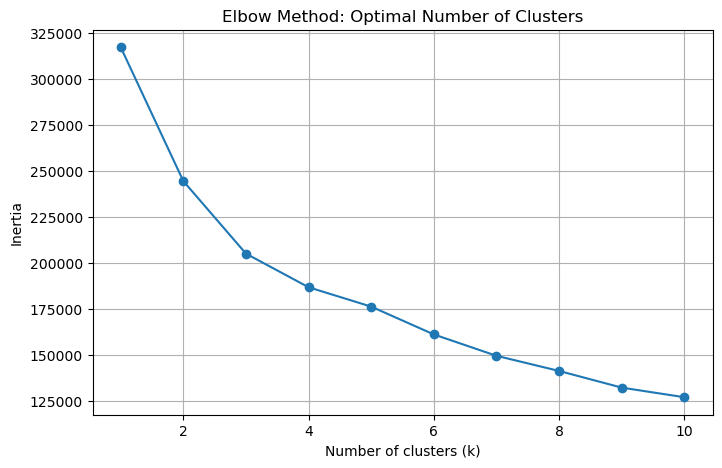

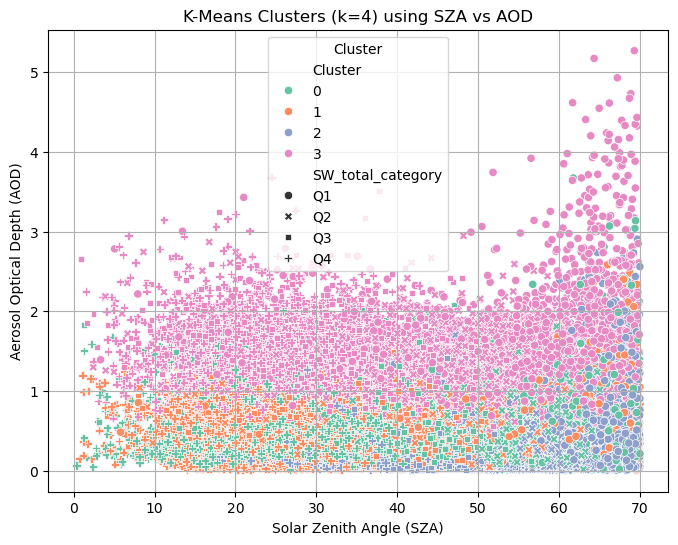

In [107]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Part 2: Unsupervised Learning – Radiation Pattern Clustering

# 2.1 K-Means Clustering
features = ["SZA", "AOD", "COD", "CLD_FRAC", "UW", "TO3", "Pressure", "BSA", "WSA"] # this defines input features - excluding any SW variables
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(df[features]) # now we normalize the defined inputs 

# elbow method to find optimal number of clusters
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# plot the elbow curve 
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method: Optimal Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# analyze if clusters align with SW_total_category
kmeans_final = KMeans(n_clusters=4, random_state=42)
df["Cluster"] = kmeans_final.fit_predict(X_scaled)

plt.figure(figsize=(8, 6)) # new plot that visualize clusters using two features (SZA and AOD)
sns.scatterplot(data=df, x="SZA", y="AOD", hue="Cluster", palette="Set2", style="SW_total_category")
plt.title("K-Means Clusters (k=4) using SZA vs AOD")
plt.xlabel("Solar Zenith Angle (SZA)")
plt.ylabel("Aerosol Optical Depth (AOD)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

# 2.2 Interpretation
# Based on the elbow plot, choosing k=4 clusters seems like a good call since the drop in inertia starts to flatten out after that point.
# When I plotted the clusters using SZA and AOD, I noticed that a lot of the separation happens vertically — especially by AOD. 
# Cluster 3 (the pink one) mainly covers the higher AOD values, while the other clusters are more concentrated in the lower range. 
# This makes me think AOD has a big influence on how the clusters form, maybe more than SZA. 
# When I compared the clusters to SW_total_category, there is some overlap between them — like Q4 (the highest shortwave radiation group) tends to show up more in areas with low AOD and lower SZA. 
# But the clusters don’t completely line up with the radiation categories. That probably means these atmospheric variables explain part of the pattern in radiation levels, but not the whole story. 
# Anyways, the clusters make some sense and show real differences in atmospheric conditions, but they don’t perfectly match the solar radiation categories.

In [108]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Part 3: Supervised Learning – Predicting Solar Radiation

# 3.1 Regression – Predicting SW_total
X = df[["SZA", "AOD", "COD", "CLD_FRAC", "UW", "TO3", "Pressure", "BSA", "WSA"]] # create our X target features 
y = df["SW_total"] # create our y SW total 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # this splits our data into training and testing sets

# trains the decision tree regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)

# trains the random forest regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# report metrics, RMSE and R², and evaluate the two models 
print("Decision Tree:")
print("  RMSE:", np.sqrt(mean_squared_error(y_test, pred_dt)))
print("  R²:", r2_score(y_test, pred_dt))

print("\nRandom Forest:")
print("  RMSE:", np.sqrt(mean_squared_error(y_test, pred_rf)))
print("  R²:", r2_score(y_test, pred_rf))

# interpret feature importances from the random forest model.
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances (Random Forest):")
print(importances)

# the Random Forest model seems to perform significantly better than the Decision Tree model due to its lower error and higher R²

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# 3.2 Classification – Predicting SW_total_category 

y_class = df["SW_total_category"] # create classification target 

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_class, test_size=0.2, random_state=42) # split our classification data into training or testing sets

# trains the KNN classifier
knn = KNeighborsClassifier()
knn.fit(X_train_cls, y_train_cls)
pred_knn = knn.predict(X_test_cls)

# trains the Gaussian NB
nb = GaussianNB()
nb.fit(X_train_cls, y_train_cls)
pred_nb = nb.predict(X_test_cls)

# report classification accuracy, precision, recall, and show a confusion matrix
def show_metrics(name, y_true, y_pred):
    print(f"\n{name}")
    print("  Accuracy:", accuracy_score(y_true, y_pred))
    print("  Precision:", precision_score(y_true, y_pred, average="macro"))
    print("  Recall:", recall_score(y_true, y_pred, average="macro"))
    print("  Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# report metrics 
show_metrics("K-Nearest Neighbors", y_test_cls, pred_knn)
show_metrics("Gaussian Naive Bayes", y_test_cls, pred_nb)

# The Random Forest Regressor outperformed the Decision Tree due to its lower RMSE and higher R² (0.80). This means it predicted SW_total more accurately.
# The Random Forest Regressor also showed that SZA was the most important feature.
# For classification, Gaussian NB slightly beats the K-Nearest Neighbors with better accuracy and precision.
# Both models struggled with the middle categories like Q2 and Q3, but Naive Bayes gave more balanced results.
# Between all 4, the Random Forest was the strongest model as it excelled in performance and interpretability.

Decision Tree:
  RMSE: 140.40395009947554
  R²: 0.5999174012194017

Random Forest:
  RMSE: 98.99863952968269
  R²: 0.801093276847922

Feature Importances (Random Forest):
SZA         0.709647
CLD_FRAC    0.070578
UW          0.057884
AOD         0.034998
Pressure    0.030434
TO3         0.028942
BSA         0.025163
COD         0.023467
WSA         0.018887
dtype: float64

K-Nearest Neighbors
  Accuracy: 0.6472675656493967
  Precision: 0.6471233432858199
  Recall: 0.6466984149657768
  Confusion Matrix:
 [[1227  391  108   38]
 [ 373  916  357  100]
 [  58  367 1020  315]
 [   5   58  315 1397]]

Gaussian Naive Bayes
  Accuracy: 0.6572036905606813
  Precision: 0.6618897529727427
  Recall: 0.656831403759655
  Confusion Matrix:
 [[1244  384  109   27]
 [ 295 1059  297   95]
 [  43  457  957  303]
 [   4    5  396 1370]]


In [109]:
# Part 4: Reflection and Recommendation

# After running the models, it’s clear that Solar Zenith Angle (SZA) was the most important feature for predicting shortwave radiation. A few others like cloud fraction and water vapor mattered too, but not nearly as much.
# The clusters kind of made sense — there were some patterns based on AOD and SZA — but they didn’t match up super well with the radiation categories. Same thing with classification: both models struggled a bit with the middle groups (Q2 and Q3), which makes sense because those categories are less distinct.
# Out of everything I tried, the Random Forest Regressor worked the best. It had the lowest error and explained the most variance in the radiation data. Plus, it helped show which features actually mattered. If I had to use a classification model, I’d go with Gaussian Naive Bayes since it was a bit more accurate than KNN.